# Assessing Measures to Decrease Fatalities from Police Shootings

### Katie Wetstone
DS200 Final Project, May 2019

# INTRODUCTION

Over one thousand people in the United States were killed by police in 2016.<sup>1</sup> While it is difficult to obtain comprehensive, standardized data, estimates show that the rate of police killings in the US dwarfs that in other high-income countries.<sup>2</sup>
<img src="country_shootings.png" width=500>

In addition to presenting a public health issue, police-related fatalities disproportionately affect communities of color and deepen racial inequality.<sup>3</sup> Generally, tactics to decrease police fatalities fall into two buckets:
1.	<b>Police training</b>: Analysis by Campaign Zero found that police departments with limits on police use of force killed substantially fewer people.<sup>4</sup>
2.	<b>Gun control</b>: The prevalence of gun ownership is often credited for the gap between killings in the US and in other high-income countries.<sup>5</sup> 

### <i>Research Question:</i> Can state-level legislation regarding police training and gun control reduce the fatality rate of police-civilian interactions?
National gridlock and the influence of the NRA complicate action in Congress on police training and gun control, increasing the importance of effective state-level actions. My research seeks to determine whether any state-level legislation has a significant impact on reducing police killings and, if so, which are the most impactful. The goal is to enable state legislators to either promote the most effective state-level policies or, if there are none, to advocate more strongly for federal action.

#### Dataset
The research relies on a crowd-sourced database of police killings dating back to 2014.<sup>6</sup> The dataset includes information on each victim’s age, gender, race, location, whether or not they were armed, whether or not they were killed, and a short summary of the circumstances. The crowd-sourced database used here is one of the most extensive datasets available describing nationwide police shootings.

I created a csv with compiled state-level data on police training and gun control by drawing from a variety of sources, which are credited in the `states_README` dataframe shown when the dataset is imported in the EDA section.

#### Methodology
I will use a logistic regression to determine which, if any, state-level characteristics had significant influence on fatality. State-level characteristics are added to the police shooting data, and then a logistic model is created to try and predict whether or not the victim was killed in each incident. In addition to the state-level features, I tested numerous other individual-level features based on the information in the police shootings dataset, including race, gender, and various characteristics of the circumstances (generated by performing text analysis on the summaries of each incident).

The significance of state-level characteristics is assessed based on the bootstrapped distribution of the coefficient for that characteristic. A feature is  considered significant if the 95% confidence interval does not include zero. The main goal is not to create the most effective model to predict whether or not someone was killed, but rather to assess which variables are the best predictors of fatality.

<font size="-3">    
    <sup>1</sup> "The Counted." <i>The Guardian</i>. Updated 2016. <a href="https://www.theguardian.com/us-news/ng-interactive/2015/jun/01/the-counted-police-killings-us-database">link</a>
<br><sup>2</sup> Lartey, Jamiles. "By the numbers: US police kill more in days than other countries do in years." <i>The Guardian.</i> 9 June 2015. <a href="https://www.theguardian.com/us-news/2015/jun/09/the-counted-police-killings-us-vs-other-countries">link</a>
<br><sup>3</sup> Lopez, German. "There are huge racial disparities in how US police use force." <i>Vox.</i> 14 Nov 2018. <a href="https://www.vox.com/identities/2016/8/13/17938186/police-shootings-killings-racism-racial-disparities">link</a>
<br><sup>4</sup> Police Use of Force Project. "Policy Database." <a href="http://useofforceproject.org/#project">link</a>
    <br><sup>5</sup> Lopez, German. "America's gun problem, explained." <i>Vox.</i> 14 Feb 2019. <a href="https://www.vox.com/2015/10/3/9444417/gun-violence-united-states-america">link</a>
<br><sup>6</sup>https://docs.google.com/spreadsheets/d/1cEGQ3eAFKpFBVq1k2mZIy5mBPxC6nBTJHzuSWtZQSVw/edit#gid=1144428085
</font>

# PART 1: EDA and Feature Engineering

Import necessary libraries and define useful EDA functions:

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
import re

def missing_counts(data):
    """
    Given a dataframe, returns a series showing the number of missing
    values for each column of the dataframe. Indices are column
    names and are sorted in descending order.
    """
    missing_counts = (data.isnull()
                  .sum(axis=0)
                  .sort_values(ascending=False))
    return missing_counts

### DATASET 1: Import and conduct EDA on police shootings dataset

`shootings` dataset:
- Crowd-sourced databased of police shootings dating back to 2014
- Source: https://docs.google.com/spreadsheets/d/1cEGQ3eAFKpFBVq1k2mZIy5mBPxC6nBTJHzuSWtZQSVw/edit#gid=1144428085

In [2]:
sheet_url = 'https://docs.google.com/spreadsheets/d/'\
    '1cEGQ3eAFKpFBVq1k2mZIy5mBPxC6nBTJHzuSWtZQSVw/edit#gid=1144428085'
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
shootings = pd.read_csv(csv_export_url)
shootings_original = shootings.copy()
shootings.head(2)

,Timestamp,Date Searched,State,County,City,Agency Name,Victim Name,Victim's Age,Victim's Gender,Race,...,Name of Officer or Officers,Shootings,Was the Shooting Justified?,Receive Updates?,Name,Email Address,Twitter,Date of Incident,Results Page Number,Unnamed: 26
0,8/20/2014 12:06:49,10/15/1986,AZ - Arizona,maricopa,Phoenix,phoenix police,David Valenzuela,24.0,Male,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8/20/2014 12:09:29,10/15/1986,TX - Texas,Guadalupe,cibolo,cibolo police department,Kennen Marksbury,41.0,Male,White,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [274]:
print('All column names and their data types in the shootings dataframe:\n')
print(shootings.dtypes)

All column names and their data types in the shootings dataframe:

Timestamp                       object
Date Searched                   object
State                           object
County                          object
City                            object
Agency Name                     object
Victim Name                     object
Victim's Age                   float64
Victim's Gender                 object
Race                            object
Hispanic or Latino Origin       object
Shots Fired                    float64
Hit or Killed?                  object
Armed or Unarmed?               object
Weapon                          object
Summary                         object
Source Link                     object
Name of Officer or Officers     object
Shootings                       object
Was the Shooting Justified?    float64
Receive Updates?                object
Name                            object
Email Address                   object
Twitter                         obje

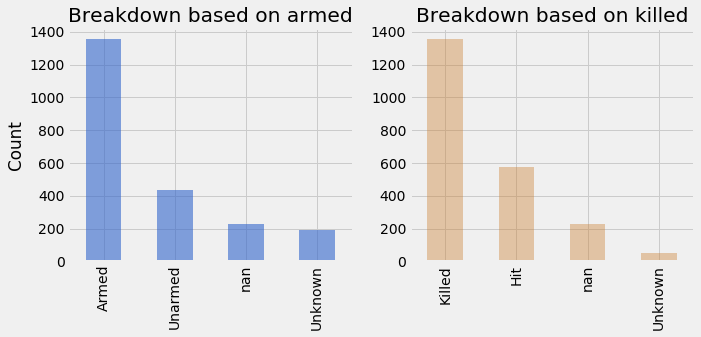

61 % of the dataset are marked as killed


In [275]:
# EDA: plot demographic breakdown based on armed and killed
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
g = (shootings['Armed or Unarmed?'].value_counts(dropna=False)
     .plot(kind='bar',color=(0.2, 0.4, 0.8, 0.6)))
g.set_ylabel('Count')
g.set_title('Breakdown based on armed')
plt.subplot(1,2,2)
g2 = (shootings['Hit or Killed?'].value_counts(dropna=False)
      .plot(kind='bar',color=(0.8, 0.5, 0.2, 0.4)))
g2.set_title('Breakdown based on killed')
plt.show();

print(100*shootings['Hit or Killed?'].value_counts(dropna=False)[0] 
      // len(shootings),'% of the dataset are marked as killed')

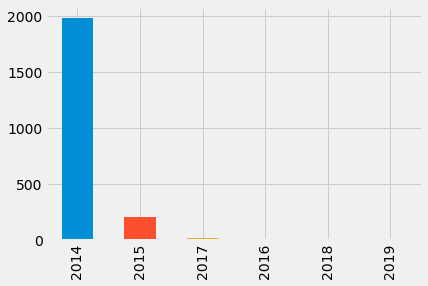

In [276]:
# EDA: assess what years are in the dataset
shootings['Timestamp'].head()
shootings['date'] = (pd.to_datetime(
    shootings['Timestamp'], format='%m/%d/%Y %H:%M:%S'))
shootings['date'].head()
shootings['year'] = shootings['date'].dt.year
shootings.loc[:,['Timestamp','date','year']].head()
shootings['year'].value_counts().plot(kind='bar');

### Clean police shootings dataset

Assess the presence of missing values in the shootings dataset, and drop columns that have too many missing values to be useful in analysis. If a column has 500 or more rows with missing values (out of 2,207 rows total) it is dropped.

In [277]:
def select_columns(data):
    """
    Given a dataframe, drops any columns that have more than 
    500 missing values and returns the filtered dataframe.
    """
    shoot_missing = missing_counts(data)
    drop_features = shoot_missing[shoot_missing >= 500].index.tolist()

    print('Dropped columns:', drop_features)
    
    # drop columns with tons of missing values
    data = data.drop(columns = drop_features)
    
    return data

def rows_to_drop(data):
    """
    Given a dataframe with the column 'Hit or Killed?', returns 
    a list of indices that have missing values in that column.
    """
    drop_rows_df = data[data['Hit or Killed?'].isna()]
    
    return drop_rows_df.index.tolist()

def drop_rows(data, rows_idx):
    """
    Given a dataframe and a list of row indices, returns the 
    dataframe with the rows in the list of indices removed.
    """
    print('Dropped',len(rows_idx),'rows based on missing values.',
          'Will still have',len(data)-len(rows_idx),'rows to work with.')
    data = data.drop(axis=1, index=rows_idx)
    
    return data

def rename_vars(data):
    """
    Renames variables in the 'shootings' dataset for convenience.
    Requires columns with the names 'Armed or Unarmed?', 'Hit or Killed?',
        'Victim's Age', 'Victim's Gender', and 'Hispanic or Latino Origin'.
    """
    # Make key variables easier to work with
    data['unarmed'] = data['Armed or Unarmed?'] == 'Unarmed'
    data['killed'] = data['Hit or Killed?'] == 'Killed'
    data['unarmed_kill'] = ((data['unarmed'] == True) 
                                 & (data['killed']==True))
    data = data.rename(columns={'Victim\'s Age':'age', 
                                'Victim\'s Gender':'female',
                                'Hispanic or Latino Origin':'HispLat'})
    
    return data

In [278]:
test_drop_rows_df = shootings[shootings['Hit or Killed?'].isna()]
test_drop_rows_missing = missing_counts(test_drop_rows_df)
test_drop_rows_missing[test_drop_rows_missing > 0]

Weapon                         227
Summary                        227
Agency Name                    227
Victim Name                    227
Victim's Age                   227
Victim's Gender                227
Race                           227
Hispanic or Latino Origin      227
Shots Fired                    227
Hit or Killed?                 227
Armed or Unarmed?              227
State                          227
Source Link                    227
County                         227
Name of Officer or Officers    227
Was the Shooting Justified?    227
Receive Updates?               227
Date of Incident               227
Results Page Number            227
City                           227
Twitter                        225
Name                           222
Email Address                  201
Unnamed: 26                     65
dtype: int64

As shown above, the rows that are missing values in the column `Hit or Killed?`, which is the column that the model will aim to predict, also have missing values for all of the other columns from the original dataset. This implies that these rows are entirely corrupted or included by mistake, and therefore dropping them is justified.

Apply the functions defined above to clean the shootings dataset:

In [279]:
def clean_shootings(data):
    """
    Given a dataframe of the original shootings dataset imported  
    from the csv file, cleans the data based on the above  
    functions and returns the dataframe.
    """
    # drop columns with an excessive number of missing values
    data = select_columns(data)
    
    # drop rows with an excessive number of missing values
    drop_rows_idx = rows_to_drop(data)
    data = drop_rows(data, drop_rows_idx)
    
    # rename key variables to make the dataset easier to navigate
    data = rename_vars(data)
    
    return data
    
shootings = clean_shootings(shootings)
shootings.head(3)

Dropped columns: ['Twitter', 'Name', 'Email Address', 'Name of Officer or Officers', 'Shots Fired', 'Results Page Number', 'Date of Incident', 'Unnamed: 26', 'Receive Updates?', 'Was the Shooting Justified?', 'County', "Victim's Age"]
Dropped 227 rows based on missing values. Will still have 1981 rows to work with.


,Timestamp,Date Searched,State,City,Agency Name,Victim Name,female,Race,HispLat,Hit or Killed?,Armed or Unarmed?,Weapon,Summary,Source Link,Shootings,date,year,unarmed,killed,unarmed_kill
0,8/20/2014 12:06:49,10/15/1986,AZ - Arizona,Phoenix,phoenix police,David Valenzuela,Male,NaN,NaN,Killed,Armed,Handgun,Man in wheelchair threatened two officers with...,http://www.fox10phoenix.com/story/18078667/man...,NaN,2014-08-20 12:06:49,2014,False,True,False
1,8/20/2014 12:09:29,10/15/1986,TX - Texas,cibolo,cibolo police department,Kennen Marksbury,Male,White,Not of Hispanic or Latino origin,Killed,Armed,Handgun,shot in his own house,http://www.mysanantonio.com/news/local_news/ar...,NaN,2014-08-20 12:09:29,2014,False,True,False
2,8/20/2014 12:11:57,10/15/1986,NJ - New Jersey,Mountain lakes,Mountain Lakes PD,Leonardo Parera,Male,White,NaN,Killed,Armed,Handgun,Man shot his coworker. Police responded. He ex...,http://www.nj.com/news/index.ssf/2011/10/motiv...,NaN,2014-08-20 12:11:57,2014,False,True,False


### Feature engineering using police shootings dataset

#### Text Analysis Features

The `Summary` column of the police shootings dataset contains much more information that is not captured by the existing columns. I first read a handful of random samples of summaries from the dataset to get a sense of what is included and what text patterns reappear. I then tried a variety of text analysis methods to extract information that could be correlated with whether or not someone was killed, as shown below.

For each variable I generated, I checked how many `True` values it returned from the dataset and how much difference it revealed between those who were killed and those who were not. This determined whether I included the variable in my model.

In [280]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# create a copy so that the original dataset is not modified
text_tests = shootings.copy() 
text_tests['Summary'] = text_tests['Summary'].str.lower()

# create a dataframe to keep track of the results of each test
test_df = pd.DataFrame(index=['False_pctkilled','True_pctkilled',
                              'False_counts','True_counts','NA_counts'])

def test_regex_col(colname, regstring, data=text_tests, test_df=test_df):
    """
    Given a dataframe, a name for the new column, a regex string to
    search for, and a dataframe of test results, returns a dataframe 
    that searches for each regex string and returns a dataframe 
    indicating:
    - breakdown of % killed based on the result of the regex search
    - value counts for the new column created by the 
        regex search (True, False, NA)
    """
    data[colname] = data['Summary'].str.contains(regstring,regex=True)
    grp_killed = data.groupby(colname).agg({'killed':np.mean})
    vc = data[colname].value_counts(dropna=False)
    test_df[colname] = [round(grp_killed['killed'][False],3), 
                        round(grp_killed['killed'][True],3), 
                        vc[False].astype(str), 
                        vc[True], 
                        sum(data[colname].isna())]
    
    return test_df

# define full dict mapping column names to regex search strings
regex_test_dict = {'drugs':'drugs?|raid|pcp|narcotics?|marijuana',
                   'alcohol':'drunk|intoxicated?|drinking|alcohol',
                   'mh':'suicide|suicidal|mental health|schizophren'\
                       '|autis',
                   'teen':'teen|underage|(1[0-9]|2[01])[- ]year[- ]old',
                   'child':'school| kid| child| baby| toddler|' \
                        '[^1-9][1-9][- ]year[- ]old',
                   'offduty':'off[- ]?duty',
                   'mult_cops':'officers',
                   'nonlethal':'tase|taze|non-?lethal (?!injuries).*|'\
                       'bean[- ]?bag',
                   'night':'night|dark|([789](:\d\d)? ?p.?m.?)|' \
                        '((10|11)(:\d\d)? ?p.?m.?)|[1234]:\d\d ?a.?m.?|' \
                        '12:\d\d ?a.?m.?',
                   'chase':'pursuit|chase|chasing',
                   'noted_armed':'armed|(holding|with) a '\
                       '(rifle|gun|weapon)|gunman|knife|'\
                       '(shot|fired) at officer'
                  }
# add combinations of text analysis variables to dictionary
regex_test_dict['substances'] = regex_test_dict['drugs'] + '|' \
            + regex_test_dict['alcohol']
regex_test_dict['young'] = regex_test_dict['teen'] + '|' \
            + regex_test_dict['child']

# iterate through regex string dictionary
for key, val in regex_test_dict.items():
    test_df = test_regex_col(key, val)
    
test_df.transpose()

,False_pctkilled,True_pctkilled,False_counts,True_counts,NA_counts
drugs,0.678,0.717,1759,120,102
alcohol,0.678,0.791,1836,43,102
mh,0.675,0.759,1771,108,102
teen,0.681,0.643,1823,56,102
child,0.681,0.652,1813,66,102
offduty,0.682,0.6,1834,45,102
mult_cops,0.664,0.702,1064,815,102
nonlethal,0.675,0.785,1786,93,102
night,0.683,0.654,1717,162,102
chase,0.688,0.63,1633,246,102


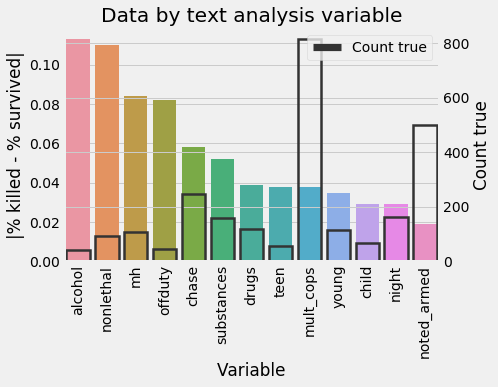

In [281]:
# create modified dataframe formatted to create a catgorical boxplot
graph_test_df = test_df.transpose()
graph_test_df.reset_index(inplace=True)
graph_test_df.rename(columns={'index':'Text analysis variable'},
                inplace=True)
graph_test_df['diff'] = np.abs(graph_test_df['False_pctkilled'] - \
                          graph_test_df['True_pctkilled'])
graph_test_df.sort_values('diff',ascending=False,inplace=True)

# create boxplot showing difference in % killed for each variable
ax = (sns.barplot(x='Text analysis variable',y='diff',
                  data=graph_test_df))
ax.set_xlabel('Variable')
ax.set_ylabel('|% killed - % survived|')
ax.set_title('Data by text analysis variable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# add boxplot showing number of True values generated by each variable
ax2 = ax.twinx()
sns.barplot(x='Text analysis variable', y='True_counts',
            data=graph_test_df,facecolor=(1, 1, 1, 0),errcolor=".2", 
            edgecolor=".2",linewidth=2.5)
ax2.legend(labels=['Count true'],loc=1)
ax2.set_ylabel('Count true')

plt.show();

Axes:
- `|% killed - % survived|`: absolute value of the difference between% killed and % survived for all rows where the x-axis variable is True
- `Count true`: number of rows in the dataset for which the text analysis variable is True

Added features should both distinguish between killed and not killed, and be true for enough of the dataset that they do not cause over-fitting due to reliance on rarely occuring values. For example, `alcohol` alone has a much larger absolute value difference betwene % killed and % survived than `alcohol` and `drugs` combined (`substances`), but applies to a very small portion of the dataset. Based on the exploration of text analysis features, I decided to include the following in my model. Each indicates whether the concept listed is mentioned in the `Summary` column of the shootings dataset.

- `substances`: either drug-related or alcohol-related issues
- `mh`: mental health issues
- `young`: someone 21 or younger was involved
- `offduty`: an off-duty officer was involved
- `mult_cops`: there was more than one officer involved
- `nonlethal`: an attempt to use non-lethal force, such as a taser, was made

In [282]:
def add_regex_col(data, colname, regstring, searchcol='Summary'):
    """
    Given a dataframe, a new column name, a regex string, and (optional)
    a column to search through, returns a dataframe with a column
    added with the result of the regex string search (True/False).
    """
    data[colname] = data[searchcol].str.contains(regstring, regex=True)
    
    return data
    
def add_text_analysis(data):
    """
    Given a cleaned dataframe from the shootings csv file, adds all
    regex search columns of interest based on the 'Summary' column
    and returns the dataframe.
    """
    data['Summary'] = data['Summary'].fillna('None')
    data['Summary'] = data['Summary'].str.lower()
    
    regex_cols_dict = {
        'substances':
        'drugs?|raid|pcp|narcotics?|marijuana|drunk|intoxicated?|'\
            'drinking|alcohol',
        'offduty':'off[- ]?duty',
        'mh':'suicide|suicidal|mental health|schizophren|autis',
        'mult_cops':'officers',
        'young':
        'teen|underage|(1[0-9]|2[01])[- ]year[- ]old|school| kid|'\
            ' child| baby| toddler|[^1-9][1-9][- ]year[- ]old',
        'nonlethal':'tase|taze|non-?lethal (?!injuries).*|bean[- ]?bag'
    }
    for key, val in regex_cols_dict.items():
        data = add_regex_col(data, key, val)

    data = data.drop(columns='Summary')
    
    return data

#### Demographic Features

Before creating features based on demographics in the dataset (race, gender, and Hispanic/Latino origin), I performed some additional EDA on the breakdown of the dataset based on these values.

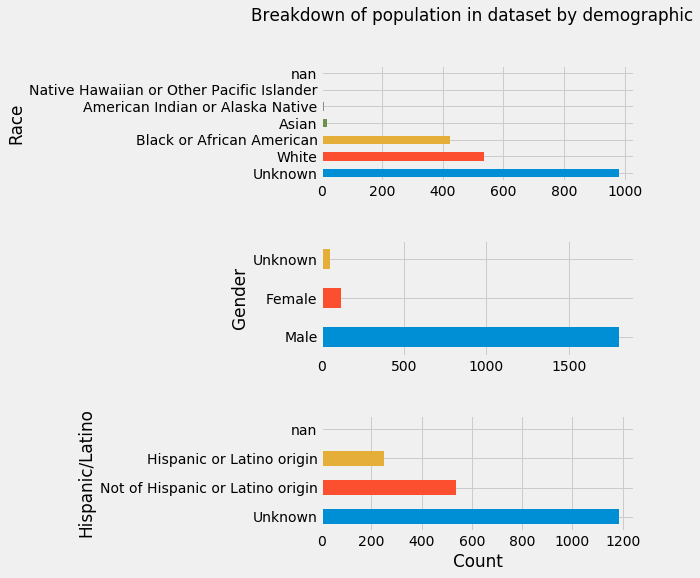

In [283]:
fig = plt.figure(figsize=(5,8))
fig.subplots_adjust(wspace=0.5,hspace=0.5)
plt.subplot(3,1,1)
plt.suptitle('Breakdown of population in dataset by demographic')
g = shootings['Race'].value_counts(dropna=False).plot(kind='barh')
g.set_ylabel('Race')
plt.subplot(3,1,2)
g = shootings['female'].value_counts(dropna=False).plot(kind='barh')
g.set_ylabel('Gender')
plt.subplot(3,1,3)
g = shootings['HispLat'].value_counts(dropna=False).plot(kind='barh')
g.set_xlabel('Count')
g.set_ylabel('Hispanic/Latino');

Since there are so few rows that are `Unknown` in the gender column, it is unlikely to compromise the dataset to drop those rows. `Unknown` values constitute too many rows in the `Race` and `Hispanic or Latino Origin` columns to drop these unknowns.

In [284]:
def ohe_race(data):
    """
    One-hot-encodes race. New cols are of the form race_VALUE
    """
    # replace all race values with shorter values to use as col names
    race_dict = {'Black or African American':'Black',
                 'American Indian or Alaska Native':'Native',
                 'Native Hawaiian or Other Pacific Islander':'Pacific'}
    data['Race'].replace(race_dict, inplace=True)
    
    cats = ['Unknown','White','Black','Asian','Native','Pacific']
    cat_type = CategoricalDtype(categories=cats)
    data = pd.get_dummies(data, prefix='',prefix_sep='',
                          columns=['Race'],drop_first=False)
    data.drop(columns='Unknown',inplace=True)

    return data

def clean_sex(data):
    """
    Given a dataframe with the column 'female', drops rows with 
    unknown values and converts Male & Female to 0 & 1 respectively.
    """
    print('Dropped',sum(data['female'] == 'Unknown'),
          'rows with unknown values for sex.')
    data = data[data['female'] != 'Unknown']
    data['female'].replace({'Male':0,'Female':1}, inplace=True)
    
    return data

def ohe_HispLat(data):
    """
    One-hot-encodes Hispanic or Latino origin. New cols are of the form 
    'histplat' and 'not_hisplat'.
    """
    # replace all values with shorter values to use as col names
    data['HispLat'].replace({'Not of Hispanic or Latino origin':
                             'not_hisplat',
                            'Hispanic or Latino origin':'hisplat'}, 
                            inplace=True)
    data['HispLat'] = data['HispLat'].fillna('Unknown')
    
    cats = ['Unknown','not_hisplat','hisplat']
    cat_type = CategoricalDtype(categories=cats)
    data = pd.get_dummies(data, prefix='',prefix_sep='',
                         columns=['HispLat'],drop_first=False)
    data = data.drop(columns='Unknown')
    
    return data

def filter_feature_columns(data, keepcols):
    """
    Filter the data to only included necessary columns.
    """
    data = data.loc[:,keepcols]
    
    return data

Apply the functions defined above to add features to the shootings dataset:

In [285]:
def add_shootings_features(data):
    """
    Given a cleaned dataframe from the shootings csv file,
    adds features based on the functions above and returns the dataframe
    after feature engineering.
    """
    # add text analysis features
    data = add_text_analysis(data)
    
    # one-hot encode race, clean gender, and one-hot encode 
    # Hispanic or Latino origin
    data = ohe_race(data)
    data = clean_sex(data)
    data = ohe_HispLat(data)
    
    # filter the dataset to only include the columns that will be
    # used as features in the model
    keep_features = ['State','female','unarmed','killed','substances',
                     'offduty', 'mh', 'mult_cops', 'young', 'nonlethal',
                     'Black', 'White', 'hisplat','not_hisplat']
    data = filter_feature_columns(data, keep_features)

    data.replace({True:1, False:0}, inplace=True)
    
    return data

shootings = add_shootings_features(shootings)
shootings.head(2)

Dropped 53 rows with unknown values for sex.


/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,State,female,unarmed,killed,substances,offduty,mh,mult_cops,young,nonlethal,Black,White,hisplat,not_hisplat
0,AZ - Arizona,0,0,1,0,0,0,1,0,0,0,0,0,0
1,TX - Texas,0,0,1,0,0,0,0,0,0,0,1,0,1


The `shootings` dataframe now has the following columns:

In [286]:
print(shootings.columns.tolist())

['State', 'female', 'unarmed', 'killed', 'substances', 'offduty', 'mh', 'mult_cops', 'young', 'nonlethal', 'Black', 'White', 'hisplat', 'not_hisplat']


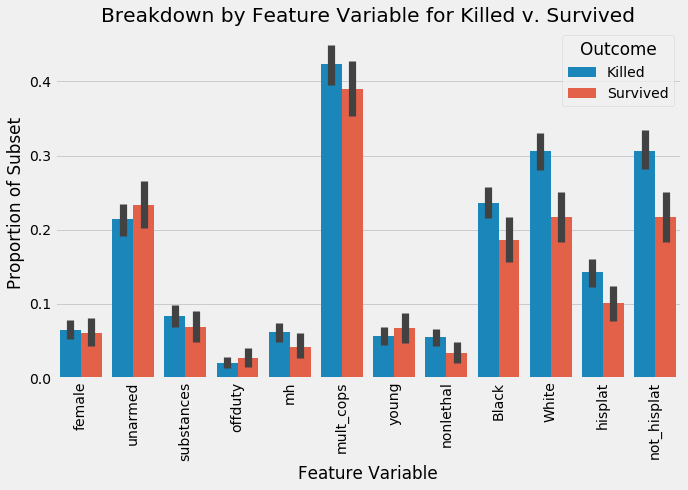

In [287]:
# show how the outcome of incidents varies for each feature variable 
for_graph = shootings.melt('killed')
ft_vars = ['female','unarmed','substances','offduty','mh','mult_cops',
           'young','nonlethal','Black','White','hisplat','not_hisplat']
for_graph = for_graph[for_graph['variable'].isin(ft_vars)]
for_graph['killed'].replace({0:'Survived',1:'Killed'},inplace=True)
for_graph.rename(columns={'killed':'Outcome'},inplace=True)

fig = plt.figure(figsize=(10,6))
ax = sns.barplot(x='variable',y='value',hue='Outcome',data=for_graph)
ax.set_title('Breakdown by Feature Variable for Killed v. Survived')
ax.set_ylabel('Proportion of Subset')
ax.set_xlabel('Feature Variable');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Already, it appears that the best available feature variables are not significantly different between those that were killed and those that were not. Ideally the data set would provide more features that characterized the two outcomes very differently.

### DATASET 2: State-level characteristics

I conducted original research to compile state-level information from various sources. It can be viewed and downloaded here: 
- Information about the data: https://docs.google.com/spreadsheets/d/1XG2rEpODzzBviG-mxuSscEYDDYUpNOjZ9eFXbIBq3M8/edit#gid=692190314
- Data file: https://docs.google.com/spreadsheets/d/16oGni7XrU9ETXx0ehwLGbxUVKcADLk_fsFhwvF_GrHA/edit#gid=690094737

Details about the state-level information are in the `states_README` dataframe shown below. 

In [288]:
sheet_url = 'https://docs.google.com/spreadsheets/d/' \
    '1XG2rEpODzzBviG-mxuSscEYDDYUpNOjZ9eFXbIBq3M8/edit#gid=692190314'
csv_export_url = sheet_url.replace('/edit#gid=', 
                                   '/export?format=csv&gid=')
states_README = pd.read_csv(csv_export_url)
states_README.head(2)

,Column,Source,Explanation
0,citations,http://www.ncsl.org/research/civil-and-crimina...,State has laws allowing citations in leiu of a...
1,mh_training,http://www.ncsl.org/research/civil-and-crimina...,Mental health training is required for police


In [289]:
print('Description of columns in the states dataframe\n')
for i in range(len(states_README)):
    row = states_README.iloc[i]
    print(row['Column'],':',row['Explanation'],',',
          '\nSource:',row['Source'],'\n')

Description of columns in the states dataframe

citations : State has laws allowing citations in leiu of arrest , 
Source: http://www.ncsl.org/research/civil-and-criminal-justice/state-trends-in-law-enforcement-legislation-2014-2017.aspx 

mh_training : Mental health training is required for police , 
Source: http://www.ncsl.org/research/civil-and-criminal-justice/law-enforcement.aspx 

crisis : Laws require the establishment of crises intervention teams (in partnership with mental health service providers) , 
Source: http://www.ncsl.org/research/civil-and-criminal-justice/law-enforcement.aspx 

deesc : Deescalation training required , 
Source: https://www.apexofficer.com/police-training-requirements 

extra : Additional training requirements , 
Source: https://www.apexofficer.com/police-training-requirements 

gun_friendly : Overall rating of gun-friendliness , 
Source: https://www.gunstocarry.com/gun-laws-state/ 

open_carry : Open carry is prohibited , 
Source: https://www.theguardi

In [290]:
# import state-level data
sheet_url = 'https://docs.google.com/spreadsheets/d/' \
    '16oGni7XrU9ETXx0ehwLGbxUVKcADLk_fsFhwvF_GrHA/edit#gid=690094737'
csv_export_url = sheet_url.replace('/edit#gid=', 
                                   '/export?format=csv&gid=')
states = pd.read_csv(csv_export_url)
states_original = states.copy()
states.head(3)

,State,Full,citation,mh_training,crises,deesc,extra,gun_friendly,open_carry,bgd_check,income,crime
0,AL,Alabama,0,0,0,0,"12 hours per year, plus firearms proficiency.",5,0,0,"46,472",532
1,AK,Alaska,1,0,0,0,"None, except firearms proficiency.",5,0,0,"76,114",804
2,AZ,Arizona,0,0,0,0,8 hours per year of electives. 8 hours every 3...,5,0,0,"53,510",470


### Feature engineering using state-level data

In [291]:
def add_yearly_hrs(data):
    """
    Add a column for hours of training required of police officers 
    per year based on column with 'extra' training for each state.
    """
    # add a column for total number of hours
    data['hrs'] = data['extra'].str.findall('(\d+) hour')
    # use a temporary variable to indicate whether or not the 
    # regex result list is empty
    data['temp'] = [len(data.iloc[i]['hrs']) for i in range(len(data))]
    
    for i in data[data['temp'] != 0].index.tolist():
        # if list is not empty, set equal to first value
        data.loc[i,'hrs'] = data.loc[i]['hrs'][0]
    for i in data[data['temp'] == 0].index.tolist():
        # if list is empty (no requirement) set value to 0
        data.loc[i,'hrs'] = 0
    data['hrs'] = data['hrs'].astype(int)
    data = data.drop(columns='temp')
    
    # add a column for over how many years the number of hours
    # is required (ie. 40 hours every 2 years --> 2)
    data['extra'].replace({'(hours a|every) year':'hours per year'}, 
                          regex=True,inplace=True)
    data['yrs'] = data['extra'].str.findall('[every]? (per|\d+) years?')
    
    for i in data.index.tolist():
        entry = data.loc[i,'yrs']
        if len(entry) == 0:
            # set the number of years equal to zero if it is missing
            data.loc[i,'yrs'] = 0
        elif entry[0] == 'per':
            # if the text says 'per year' set # of years equal to 1
            data.loc[i,'yrs'] = 1
        else:
            # if the text says 'every _ years' set # equal to _
            data.loc[i,'yrs'] = entry[0]
    data['yrs'] = data['yrs'].astype(int)
    
    # calculate training hours per year
    data['yearly_hrs'] = data['hrs'] // data['yrs']
    data['yearly_hrs'] = data['yearly_hrs'].fillna(0)
    data['yearly_hrs'] = data['yearly_hrs'].astype(int)
    data = data.drop(columns=['hrs','yrs'])
    
    return data

def add_train_types(data):
    """
    Add column for different types of required training based on
    text analysis of column with 'extra' training for each state.
    """
    # create a dict mapping new column names to regex search strings
    regex_cols_dict = {'race_train':
                       'racial|bias|diversity|profiling|civil rights',
                       'medic_train':'first aid|CPR|first responder',
                       'rape_train':'rape|sexual|domestic violence'}
    
    # add columns based on regex dict
    for key, val in regex_cols_dict.items():
        data = add_regex_col(data, key, val, searchcol='extra')
    data.replace({True:1, False:0},inplace=True)
    
    return data

def ohe_gun_friendly(data):
    """
    One-hot-encodes gun friendliness. New columns of the form gfRATING.
    """
    data['gun_friendly'] = data['gun_friendly'].astype(str)
    gf_dict = {'1.0':'one',
              '2.0':'two',
              '3.0':'three',
              '4.0':'four',
              '5.0':'five'}
    data['gun_friendly'].replace(gf_dict, inplace=True)
    
    cats = list(gf_dict.values())
    cat_type = CategoricalDtype(categories=cats)
    data = pd.get_dummies(data, prefix='gf',prefix_sep='',
                          columns=['gun_friendly'],drop_first=False)
    data = data.drop(columns='gf3')
    
    return data

def convert_income(data):
    """
    Converts income from a string to an integer and takes the log.
    """
    data['income'] = data['income'].str.replace(',','')
    data['income'] = data['income'].astype(int)
    data['log_income'] = np.log(data['income'])
    data.drop(columns='income',inplace=True)
    
    return data

def deesc_dummy(data):
    """
    Converts 'deesc' from string descriptions to a binary indicator
    of whether or not there are any deescalation training requirements.
    """
    data.rename(columns={'deesc':'full_deesc'}, inplace=True)
    data['deesc'] = data['full_deesc'] != '0'
    data['deesc'].replace({True:1, False:0}, inplace=True)
    data = data.drop(columns='full_deesc')
    
    return data

Apply the functions defined above to add features to the shootings dataset:

In [292]:
warnings.filterwarnings("ignore", category=FutureWarning)

def add_states_features(data):
    """
    Given a  dataframe from the states csv file, adds features
    based on the functions above and returns the dataframe
    after feature engineering.
    """
    # add yearly hours of required training based on 'extra' column
    data = add_yearly_hrs(data)
    
    # add types of training required based on 'extra' column
    data = add_train_types(data)
    
    # one hot encode gun friendliness
    data = ohe_gun_friendly(data)
    
    # convert income and deescalation to more usable values
    data = convert_income(data)
    data = deesc_dummy(data)
    
    # also convert crime to log_crime
    data['log_crime'] = np.log(data['crime'])
    
    # filter to only include columns that will be used as features
    keep_features = ['State','citation','mh_training','crises',
                     'open_carry','bgd_check','log_crime','yearly_hrs',
                     'race_train','medic_train','rape_train','gf1',
                     'gf2','gf4','gf5','log_income','deesc']
    data = filter_feature_columns(data, keep_features)
    
    return data

states = add_states_features(states)
states.head()

,State,citation,mh_training,crises,open_carry,bgd_check,log_crime,yearly_hrs,race_train,medic_train,rape_train,gf1,gf2,gf4,gf5,log_income,deesc
0,AL,0,0,0,0,0,6.276643,12,0,0,0,0,0,0,1,10.746605,0
1,AK,1,0,0,0,0,6.689599,0,0,0,0,0,0,0,1,11.239987,0
2,AZ,0,0,0,0,0,6.152733,8,0,1,0,0,0,0,1,10.887624,0
3,AR,0,0,1,0,0,6.311735,16,1,0,0,0,0,0,0,10.687686,0
4,CA,0,1,0,1,0,6.098074,12,1,1,1,1,0,0,0,11.114967,1


The `states` dataframe now has the following columns:

In [293]:
print(states.columns.tolist())

['State', 'citation', 'mh_training', 'crises', 'open_carry', 'bgd_check', 'log_crime', 'yearly_hrs', 'race_train', 'medic_train', 'rape_train', 'gf1', 'gf2', 'gf4', 'gf5', 'log_income', 'deesc']


### MERGE: Add columns with state-level information to the police shootings dataset

In [294]:
# Prepare states columns in data dataset
def shootings_merge_prep(data):
    """
    Create and modify a 'State' column in the shootings dataframe
    that can merge with the states dataframe.
    Returns the modified shootings dataframe.
    """
    # add a column with the state abbreviation by taking a slice from
    # the full string of state (ie. 'MD - Maryland' --> 'MD')
    data['LongState'] = data['State']
    data['State'] = data['State'].str[0:3]
    data.loc[:,['State','LongState']].head()
    
    # remove whitespace
    data['State'] = data['State'].str.replace('\s+','')
    
    return data

shootings = shootings_merge_prep(shootings)

In [295]:
shootings_comb = shootings.merge(states, right_on='State',
                                 left_on='State', how = 'inner')
shootings_comb.head()

,State,female,unarmed,killed,substances,offduty,mh,mult_cops,young,nonlethal,...,yearly_hrs,race_train,medic_train,rape_train,gf1,gf2,gf4,gf5,log_income,deesc
0,AZ,0,0,1,0,0,0,1,0,0,...,8,0,1,0,0,0,0,1,10.887624,0
1,AZ,0,1,1,0,0,0,0,0,0,...,8,0,1,0,0,0,0,1,10.887624,0
2,AZ,0,0,1,1,0,0,1,0,0,...,8,0,1,0,0,0,0,1,10.887624,0
3,AZ,0,0,1,0,0,0,0,0,0,...,8,0,1,0,0,0,0,1,10.887624,0
4,AZ,0,0,1,0,0,0,1,0,0,...,8,0,1,0,0,0,0,1,10.887624,0


The merged dataframe from both `shootings` and `states` has the following columns:

In [296]:
print(shootings_comb.columns.tolist())

['State', 'female', 'unarmed', 'killed', 'substances', 'offduty', 'mh', 'mult_cops', 'young', 'nonlethal', 'Black', 'White', 'hisplat', 'not_hisplat', 'LongState', 'citation', 'mh_training', 'crises', 'open_carry', 'bgd_check', 'log_crime', 'yearly_hrs', 'race_train', 'medic_train', 'rape_train', 'gf1', 'gf2', 'gf4', 'gf5', 'log_income', 'deesc']


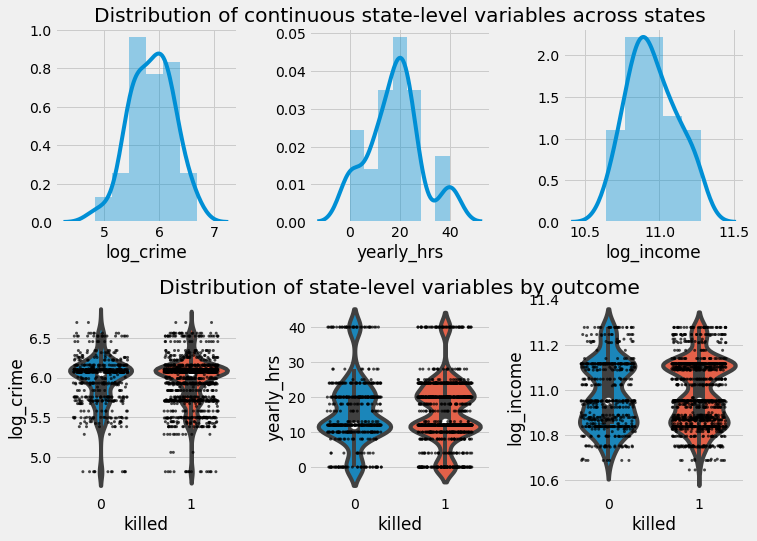

In [297]:
# show distributions of continuous variables by state
fig = plt.figure(figsize=(11,8))
fig.subplots_adjust(wspace=0.4,hspace=0.4)
continuous_vars = ['log_crime','yearly_hrs','log_income']

# plot the distribution among the states dataset
for i in range(1,4):
    plt.subplot(2,3,i)
    sns.distplot(states[continuous_vars[i-1]])
    if i == 2:
        plt.title('Distribution of continuous state-level variables'\
                  ' across states')
        
# plot the distribution of each variable based on its correlation
# with whether or not someone was killed
for i in range(4,7):
    plt.subplot(2,3,i)
    sns.violinplot(x='killed',y=continuous_vars[i-4],
                   data=shootings_comb)
    sns.stripplot(x='killed',y=continuous_vars[i-4],
                  data=shootings_comb,color='black',size=3,
                  jitter=0.3,alpha=0.7)
    if i == 5:
        plt.title('Distribution of state-level variables by outcome')

Similarly to the features from the `shootings` dataset, the distributions of the continuous state-level variables are not significantly different between those that were killed and those that were not. Ideally the data set would provide more features that characterized the two outcomes very differently.

# PART 2: Create, fit, and analyze model

### Define functions

In [298]:
def createXY(data, features, predict):
    """
    Create X and Y dataframes for regression.
    Inputs: 
        data = dataset
        features = list of columns to select as features 
        predict = column to predict as a string
    """
    X = data.loc[:,features]
    Y = data.loc[:,[predict]]
    
    return X, Y

def validate_no_missing(data):
    """
    Check that there are no missing values in the feature matrix.
    """
    missing = missing_counts(data)
    if sum(missing.values != 0) == 0:
        return True
    else:
        return False
    
def process_data(shoot_data, state_data, features, predict):
    """
    Performs full data processing pipeline.
    Inputs: uncleaned dataframe from states csv file, uncleaned
        dataframe from states csv file, features to include in
        feature matrix, columns to predict.
    Outputs: dataframe of feature matrix, dataframe of variable to predict.
    """
    # clean shootings dataset
    shoot_data = clean_shootings(shoot_data)
    
    # add features to shootings dataset
    shoot_data = add_shootings_features(shoot_data)
    
    # add features to states dataset
    state_data = add_states_features(state_data)
    
    # merge shootings and states dataframes
    shoot_data = shootings_merge_prep(shoot_data)
    combined = (shoot_data.merge(state_data, right_on='State',
                                left_on='State', how = 'inner'))
    
    # create X and Y matrices (as dataframes) for model
    X, Y = createXY(combined, features, predict)
    
    # check that there are no missing values in the feature matrix
    assert validate_no_missing(X) == True, \
    "Missing values in feature matrix."
    print('Rows in final data set:',len(X))
    
    return X, Y

### Process data, starting from original imports, using pipeline

In [299]:
# define columns to use as features
feature_cols = ['female', 'unarmed', 'substances', 'offduty', 'mh',
                'mult_cops', 'young','nonlethal', 'Black', 'White', 
                'hisplat','not_hisplat', 'citation', 'mh_training', 
                'crises','open_carry', 'bgd_check', 'log_crime', 
                'yearly_hrs', 'race_train','medic_train', 'rape_train', 
                'gf1', 'gf2', 'gf4', 'gf5', 'log_income','deesc']

# process data and create dataframes for model, starting with
# original imported csv files
X, Y = (process_data(shootings_original, states_original, 
                     feature_cols, 'killed'))
# create matrices from the X, Y dataframes
X_np, Y_np = X.values, Y.values
X.head()

Dropped columns: ['Twitter', 'Name', 'Email Address', 'Name of Officer or Officers', 'Shots Fired', 'Results Page Number', 'Date of Incident', 'Unnamed: 26', 'Receive Updates?', 'Was the Shooting Justified?', 'County', "Victim's Age"]
Dropped 227 rows based on missing values. Will still have 1981 rows to work with.
Dropped 53 rows with unknown values for sex.


/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Rows in final data set: 1922


,female,unarmed,substances,offduty,mh,mult_cops,young,nonlethal,Black,White,...,yearly_hrs,race_train,medic_train,rape_train,gf1,gf2,gf4,gf5,log_income,deesc
0,0,0,0,0,0,1,0,0,0,0,...,8,0,1,0,0,0,0,1,10.887624,0
1,0,1,0,0,0,0,0,0,0,0,...,8,0,1,0,0,0,0,1,10.887624,0
2,0,0,1,0,0,1,0,0,0,0,...,8,0,1,0,0,0,0,1,10.887624,0
3,0,0,0,0,0,0,0,0,0,1,...,8,0,1,0,0,0,0,1,10.887624,0
4,0,0,0,0,0,1,0,0,0,1,...,8,0,1,0,0,0,0,1,10.887624,0


### Use L1-regularization to do feature selection


In [300]:
def feature_selection(X_data, Y_data):
    """
    Given a feature matrix (X_data) as a dataframe and the
    prediction variable (Y_data) as a dataframe, performs
    L1 regularization and returns a list of columns with
    beta close to 0 to be dropped.
    """
    # define and fit model 
    model = LogisticRegression(penalty='l1',fit_intercept=True)
    model.fit(X_data, np.ravel(Y_data))
    
    # save the model coefficients and put into a dataframe
    betas = model.coef_.round(4)
    np.set_printoptions(suppress=True)
    betas_df = (pd.DataFrame(betas.T,
                             index=X_data.columns.tolist())
               .rename(columns={0:'Beta'}))
    
    # filter the betas dataframe based on which values are close to
    # zero and create a list of coefficients to drop
    to_drop = betas_df[np.isclose(betas_df['Beta'],0)].index.tolist()
    
    # print the results
    if len(to_drop) != 0:
        print('Drop',to_drop,'based on L1 regularization.')
    else:
        print('No columns found to drop based on L1 regularization.')
    
    return to_drop

# check the result of L1 regularization feature selection
drop_cols = feature_selection(X, Y)

# drop the columns identified by L1 regularization
X.drop(columns=drop_cols, inplace=True)

No columns found to drop based on L1 regularization.


### Fit a logistic regression to predict whether or not someone was killed

Define functions for 5-fold cross validation.

In [301]:
def log_risk(y, p_hats):
    """
    Given actual values and predicted model values,
    returns the log risk of the model.
    """
    losses = (-1)*y*np.log(p_hats) + (-1)*(1-y)*np.log(1-p_hats)
    return np.mean(losses)

def compute_CV_error(model, X_train, Y_train, k=5):
    '''
    Splits the training data into k subsets.
    For each subset, 
        fits a model holding out that subset
        computes the log loss on that subset (the validation set)
    Returns the average log loss of these k folds.

    Args:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 
        k: number of folds (defaults to 5)

    Return:
        the average validation log loss for the k splits.
    '''
    kf = KFold(n_splits=k)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train = X_train.iloc[train_idx]
        split_X_valid = X_train.iloc[valid_idx]
        split_Y_train = Y_train.iloc[train_idx]
        split_Y_valid = Y_train.iloc[valid_idx]
        
        # Fit the model on the training split
        model.fit(split_X_train, np.ravel(split_Y_train))
        p_hats = (pd.DataFrame(model.predict_proba(split_X_train))[1]
                  .values)

        # Compute the log loss on the validation split
        error = log_risk(split_Y_train['killed'].values, p_hats)
        validation_errors.append(error)

    return np.mean(validation_errors)

Use 5-fold cross validation to determine regularization hyperparameter for logistic regression

In [302]:
# define a list of regularization parameters to test
lams = np.linspace(1,30,50)
errors = []

# iterate through regularization parameter options
for lam in lams:
    model = LogisticRegression(C=lam, penalty='l2',fit_intercept=True)
    model.fit(X,np.ravel(Y))
    error = compute_CV_error(model, X, Y)
    errors.append(error)

# identify and return the best value for lambda and the best error
best_err_idx = np.argmin(errors)
best_err = min(errors)
best_lam = lams[best_err_idx]
print('Best lam:',best_lam, ', Best error:',best_err)

Best lam: 28.816326530612244 , Best error: 0.5908583333132815


Examine output of the model and evaluate model quality

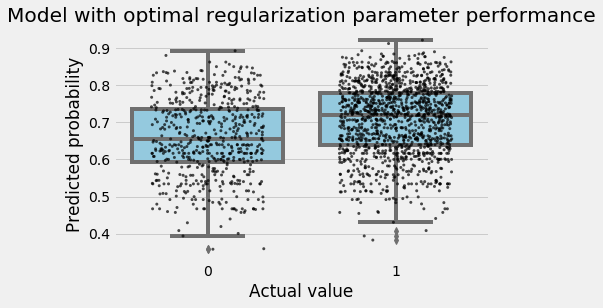

In [303]:
# initiate and fit model with best regularization parameter
model = LogisticRegression(C=best_lam, penalty='l2',fit_intercept=True)
model.fit(X,np.ravel(Y))

# store the probabilities that killed == 1 given by model
probs = pd.DataFrame(model.predict_proba(X))[1].values

ax = sns.boxplot(x = Y['killed'].values, y = probs,color='skyblue')
ax = sns.stripplot(x = Y['killed'].values, y = probs,
                   color='black',size=3,jitter=0.3,alpha=0.7)
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted probability')
ax.set_title('Model with optimal regularization parameter performance');

In [304]:
def evaluate_model(model, X, Y):
    """
    Given a model, a feature matrix (dataframe), and a result
    matrix (datafame), evaluates the model and prints its
    precision, recall, false-alarm rate, and accuracy.
    """
    # generate predicted values and get actual values from Y dataframe
    pred = model.predict(X)
    actual = Y['killed'].values
    
    # compute statistics
    TP = sum((pred==1) & (actual==1))
    TN = sum((pred==0) & (actual==0))
    FP = sum((pred==1) & (actual==0))
    FN = sum((pred==0) & (actual==1))
    
    precision = round(TP / (TP + FP),3)
    recall = round(TP / (TP + FN),3)
    false_alarm = round(FP / (FP + TN),3)
    accuracy = round((TP + TN) / len(pred),3)
    
    # print the result
    print('Precision:',precision,'Recall:', recall,
          'False-alarm rate:',false_alarm,'Accuracy:', accuracy)

evaluate_model(model, X, Y)

Precision: 0.705 Recall: 0.979 False-alarm rate: 0.919 Accuracy: 0.702


### Test different feature sets to minimize error

The list of `drop_options` below only includes the feature sets that produced the lowest errors. I also tried dropping each of the following lists:
`[rape_train]` ,  `[mh_training]` ,  `[substances]` ,  `[mult_cops]` ,  `[Black,White]` ,  `[Black,White,hisplat]` ,  `[hisplat]` ,  `[yearly_hrs]` ,  `[gun_friendly,nonlethal]` ,  `[nonlethal]` ,  `[gf1,gf2]` ,  `[gf1,gf2,gf5]` ,  `[log_crime]` ,  `[deesc,yearly_hrs]` ,  `[deesc]` ,  `[gf1,gf2,gf5,open_carry]` ,  `[race_train]` ,  `[yearly_hrs,race_train,rape]` ,  `[mh]` ,  `[log_income]` ,  and `[young]`

In [305]:
all_cols = X.columns.tolist().copy()
drop_options = [['female'],['crises'],
                ['crises','mh_training'],['offduty'],
                ['female','crises'],[]]
feature_sets = []

# iterate through options of columns to drop and append the list of
# feature_sets to try
for options in drop_options:
    ft_set = X.columns.tolist().copy()
    for col in options:
        ft_set.remove(col)
    feature_sets.append(ft_set)

In [306]:
ft_errors = []
ft_lams = []
i = 0

# define lambdas to test
lams = np.linspace(2,30,40)

# iterate through feature set options
for ftset in feature_sets:
    X_set = X.loc[:,ftset]
    
    # for each feature set, iterate through all lambda options
    lam_errors = []
    for lam in lams:
        model = LogisticRegression(C=lam, penalty='l2',fit_intercept=True)
        model.fit(X_set,np.ravel(Y))
        error = compute_CV_error(model, X_set, Y)
        lam_errors.append(error)
    
    # identify the best lambda and best error for each feature set
    lam_best_err_idx = np.argmin(lam_errors)
    lam_best_err = min(lam_errors)
    best_lam = lams[lam_best_err_idx]
    ft_lams.append(best_lam)
    ft_errors.append(lam_best_err)
    
    # print the results for each feature set
    print('Dropped:',drop_options[i],'Best lam:',round(best_lam,2), 
          ', Best error:',round(lam_best_err,4))
    i += 1

# identify best feature set, best lambda value, and best error
best_err_idx = np.argmin(ft_errors)
best_err = min(ft_errors)
best_fts = feature_sets[best_err_idx]
best_lam = ft_lams[best_err_idx]
print('\nBest feature set: dropped',drop_options[best_err_idx],
      'Best lam:',round(best_lam,2),'Best error:',round(best_err,4))

Dropped: ['female'] Best lam: 30.0 , Best error: 0.5909
Dropped: ['crises'] Best lam: 29.28 , Best error: 0.5909
Dropped: ['crises', 'mh_training'] Best lam: 28.56 , Best error: 0.5914
Dropped: ['offduty'] Best lam: 30.0 , Best error: 0.5911
Dropped: ['female', 'crises'] Best lam: 29.28 , Best error: 0.591
Dropped: [] Best lam: 27.85 , Best error: 0.5909

Best feature set: dropped [] Best lam: 27.85 Best error: 0.5909


Update model based on the best feature set found above and re-evaluate predictions.

In [307]:
# filter columns based on best feature set
X = X.loc[:,best_fts]

# redefine and refit model
model = LogisticRegression(C=best_lam, penalty='l2',fit_intercept=True)
model.fit(X,np.ravel(Y))
evaluate_model(model, X, Y)

Precision: 0.705 Recall: 0.979 False-alarm rate: 0.919 Accuracy: 0.702


### Evaluate coefficients and significance using bootstrapping

In [308]:
# store coefficients of model in a dataframe and print values
betas = model.coef_.round(4)
np.set_printoptions(suppress=True)
betas_df = (pd.DataFrame(betas.T,
                         index=X.columns.tolist())
           .rename(columns={0:'Beta'}))
betas_df

,Beta
female,0.0966
unarmed,-0.2990
substances,0.1524
offduty,-0.1931
mh,0.4599
mult_cops,0.0997
young,-0.2406
nonlethal,0.4680
Black,0.5445
White,0.4845


In [309]:
def simple_resample(n):
    """
    Args:
        n: an integer
        
    Returns:
        an array of length n of a random sample with replacement of
        the integers 0, 1, ..., n-1 to use as indices
    """
    return np.random.randint(low=0, high=n, size=n)

In [310]:
# set random seed for replicability
np.random.seed(48)

# set parameters for bootstrapping and initiate lists/dataframes to
# store the results
replicates = 500
coefs = pd.DataFrame()
boot_errs = []
n = len(X)
resample_indices = [simple_resample(n) for _ in range(replicates)]

# iterate through the desired number of bootstrap samples (replicates)
for i in range(len(resample_indices)):
    # filter data to be just bootstrap sample
    X_sample = X.iloc[resample_indices[i],:]
    Y_sample = Y.iloc[resample_indices[i],:]
    
    # fit model based only on bootstrap sample
    model.fit(X_sample,np.ravel(Y_sample))
    
    # return coefficients and add them to the coefs dataframe
    sample_coefs = model.coef_
    sample_coefs_df = pd.DataFrame(sample_coefs)
    coefs = (pd.concat([coefs, sample_coefs_df], join="outer",
                       ignore_index=True))
    
    # calculate the error for the bootstrap sample and add it to list
    sample_err = log_risk(Y_sample['killed'].values, 
                          pd.DataFrame(model.predict_proba(X))[1].values)
    boot_errs.append(sample_err)

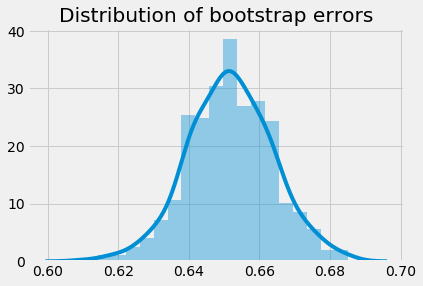

In [311]:
g = sns.distplot(boot_errs)
g.set_title('Distribution of bootstrap errors');

In [312]:
# rename columns in coeficients dataframe based on feature matrix
coefs.columns = X.columns.tolist()

# initiate dataframe to store confidence intervals
conf_intervals = {}

# iterate through columns in feature matrix and add confidence interval
# for each column to dataframe
for col in X.columns.tolist():
    col_values = coefs[col]
    col_values = col_values.sort_values()
    low, high = np.percentile(col_values,[2.5,97.5])
    conf_intervals[col] = [low, high]
conf_intervals = (pd.DataFrame(conf_intervals, index=['low','high']).
                  transpose())

# add a column for whether the 95% confidence interval contains zero
conf_intervals['significant'] = (conf_intervals['low'] * 
                                 conf_intervals['high'] > 0)

conf_intervals.sort_values('significant',ascending=False)

,low,high,significant
deesc,0.106990,0.668441,True
log_crime,-0.872683,-0.089531,True
log_income,0.111935,1.022656,True
mh,0.010350,0.985254,True
Black,0.258775,0.878199,True
White,0.242904,0.770879,True
hisplat,0.195256,0.858904,True
medic_train,-0.715954,-0.121223,True
unarmed,-0.575915,-0.037787,True
gf5,-0.679402,0.375204,False


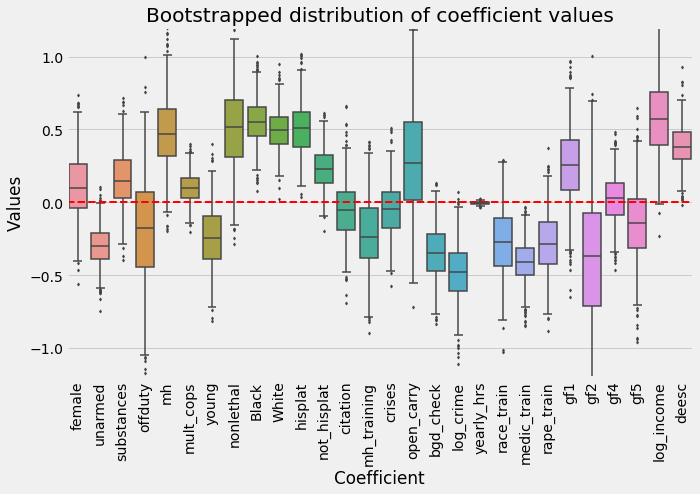

In [313]:
# melt the conf_intervals dataframe to create graph
graph_coef = coefs.transpose().reset_index().melt('index')

fig = plt.figure(figsize=(10,6))
g = sns.boxplot(x='index',y='value',data=graph_coef,
                whis=1.2,fliersize=2,linewidth=1.5)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Coefficient')
g.set_ylabel('Values')
g.axhline(0, ls='--', color='red',linewidth=2.0)
g.set_title('Bootstrapped distribution of coefficient values')
g.set_ylim(-1.2,1.2);

There are not many coefficients for which 0 is an outlier, so most of the coefficients not significant.

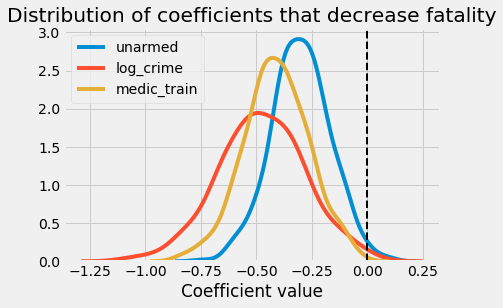

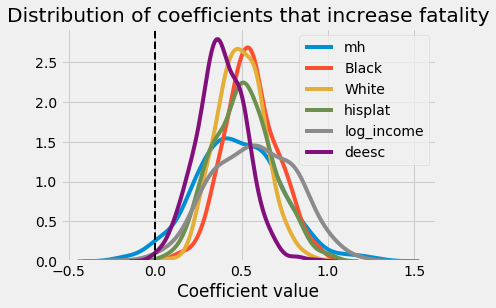

In [314]:
# create lists of features that are 95% significant based on bootstrapping
significant_neg = (conf_intervals[(conf_intervals['significant'] == True) 
                                  &(conf_intervals['high'] < 0)]
                   .index.tolist())
significant_pos = (conf_intervals[(conf_intervals['significant'] == True)
                                 & (conf_intervals['high'] > 0)]
                   .index.tolist())

# show distributions of coefficients that decrease fatality
for ft in significant_neg:
    g = sns.distplot(coefs[ft], label=ft, hist=False)
g.set_title('Distribution of coefficients that decrease fatality')
g.set_xlabel('Coefficient value')
g.axvline(0, ls='--', color='black',linewidth=2.0)
plt.show()

# show distributions of coefficients that increase fatality
for ft in significant_pos:
    g = sns.distplot(coefs[ft], label=ft, hist=False)
g.set_title('Distribution of coefficients that increase fatality')
g.set_xlabel('Coefficient value')
g.axvline(0, ls='--', color='black',linewidth=2.0)
plt.show();

In [315]:
# try model again using ONLY fts that were significant
significant_fts = significant_neg + significant_pos
X_significant = X.loc[:,significant_fts]
model_significant = LogisticRegression(C=best_lam, penalty='l2',fit_intercept=True)
model_significant.fit(X_significant,np.ravel(Y))
evaluate_model(model_significant, X_significant, Y)

Precision: 0.692 Recall: 0.996 False-alarm rate: 0.993 Accuracy: 0.691


# CONCLUSION

#### Final Model
The final model to predict the outcome of an incident (killed or survived) is:

$$ Outcome = 0.0966*female-0.299*unarmed+0.1524*substances-0.1931*offduty+0.4599*mh+0.0997*multcops-0.2406*young+0.468*nonlethal+0.5445*Black+0.4845*White+0.5047*hisplat+0.2317*nothisplat-0.0523*citation-0.2275*mhtraining-0.034*crises+0.2971*opencarry-0.3323*bgdcheck-0.4742*logcrime-0.006*yearlyhrs-0.285*racetrain-0.4023*medictrain-0.2773*rapetrain+0.2415*gf1-0.3919*gf2+0.018*gf4-0.1474*gf5+0.5913*logincome+0.3804*deesc $$

However, even the optimized model is not able to make very good predictions based on this dataset.
- Precision: 0.705
- Recall: 0.979
- False-alarm rate: 0.919
- Accuracy: 0.702

The very high false-alarm rate indicates that the model does not do a good job of identifying the relatively rare cases in the dataset in which someone is not killed. The high accuracy and recall are misleading as to the model's effectiveness because they reflect the class imbalance in the data more so than the model's performance. As shown below, the distribution of probabilities predicted does differ for those that were not killed v. those that were, but not by enough to provide meaningful predictions.

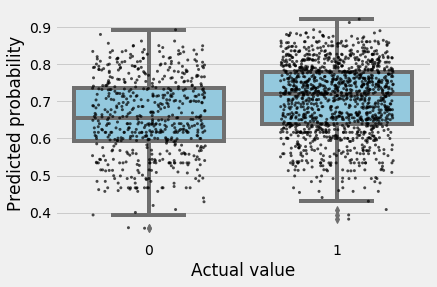

In [316]:
model = LogisticRegression(C=best_lam, penalty='l2',fit_intercept=True)
model.fit(X,np.ravel(Y))
probs = pd.DataFrame(model.predict_proba(X))[1].values

ax = sns.boxplot(x = Y['killed'].values, y = probs,color='skyblue')
ax = sns.stripplot(x = Y['killed'].values, y = probs,
                   color='black',size=3,jitter=0.3,alpha=0.7)
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted probability');

#### Limitations

A strong limitation of the dataset is selection bias. There is an overwhelming lack of systematically collected data regarding police-civilian interactions. More recent efforts by <a href="https://www.theguardian.com/us-news/ng-interactive/2015/jun/01/the-counted-map-us-police-killings">The Guardian</a> and <a href="https://www.washingtonpost.com/graphics/2019/national/police-shootings-2019/?utm_term=.2c8eb8862b88">The Washington Post</a> have made progress in consolidating data, but still focus primarily only on incidents in which violent confrontation occurred. During most of the incidents recorded in this dataset, officers did attempt to shoot a victim.  Among incidents in which there was violent confrontation, whether or not a civilian died is much more likely to depend on chance. 

Additionally, the vast majority of data points are drawn from 2014. Information about exactly when state-level laws were implemented is not clear. It is possible that the outcomes in my dataset did not have time to respond to state-level legislation, and are therefore unable to answer the research question.

#### Recommendations

More data on police-civilian interactions should be systematically tracked and released so that a better model can be created to inform funding and legislation efforts. This data should:
1.	<b>Include a wider range of incidents:</b> The predictable determining factors of fatality likely occur before an officer begins shooting at a victim. Therefore the data must include incidents with a much wider variety of outcomes—including de-escalation—and not just those that ended in violence.
2.	<b>Be up-to-date:</b> Many state-level actions have been taken recently, and multi-year old data is unlikely to reflect those changes. Data should be collected and made publicly available more promptly.